# Group project

### Import libraries and data

In [ ]:
# Library imports
import time, math, cv2, imutils, os, json, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import pandas as pd
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from sklearn import preprocessing
import joblib

### Getting Started

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###########################################################
# Change directory to the directory this notebook is in.  #
###########################################################

%cd ./drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
# !rm -rf benchmark_velocity_test.zip.1
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/2/benchmark_velocity_train.zip
# !unzip -q benchmark_velocity_train.zip -d ./benchmark_velocity_train

In [ ]:
# !rm -rf benchmark_velocity_test benchmark_velocity_test.zip
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/2/benchmark_velocity_test.zip
# !unzip -q benchmark_velocity_test.zip -d ./benchmark_velocity_test

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout --force v0.3.0 

cp references/detection/utils.py ../ &> /dev/null
cp references/detection/transforms.py ../ &> /dev/null
cp references/detection/coco_eval.py ../ &> /dev/null
cp references/detection/engine.py ../ &> /dev/null
cp references/detection/coco_utils.py ../ &> /dev/null

fatal: destination path 'vision' already exists and is not an empty directory.
Checking out files: 100% (131/131), done.
HEAD is now at be376084 version check against PyTorch's CUDA version


### Useful class/functions

In [ ]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, imgno='40'):
        self.root = root
        self.transforms = transforms
        # load all labels
        self.clip_nums = [x for x in sorted(os.listdir(self.root), key=int) if 'DS_Store' not in x]
        self.img_paths = [Path(root).joinpath(num).joinpath('imgs').joinpath(f'0{imgno}.jpg') for num in self.clip_nums]
        self.anno = [Path(root).joinpath(x).joinpath('annotation.json') for x in self.clip_nums]

    def __getitem__(self, idx):
        # load images and masks
        anno_pth = self.anno[idx]
        with open(anno_pth) as f:
          anno_data = json.load(f)
        
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        mask = np.zeros(np.array(img).shape[0:2])
        boxes = []        
        position = []   
        velocity = []
        all_boxes = []
        for car in anno_data:
            left = int(car['bbox']['left'])
            right = int(car['bbox']['right'])
            top = int(car['bbox']['top'])
            bottom = int(car['bbox']['bottom'])
            start_point = (left, top)
            end_point = (right, bottom)  
            color =  1
            thickness = -1
            # Add bounding box
            mask = cv2.rectangle(mask, start_point, end_point, color, thickness)
            if ('position' in car.keys()):
                position += [car['position']]
            if ('velocity' in car.keys()):
                velocity += [car['velocity']]
            all_boxes += [[left, top, right, bottom]]

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target["boxes"] = boxes
        target["allboxes"] = all_boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["position"] = position
        target["velocity"] = velocity

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# Code based on stack overflow answer (shorturl.at/koNPR)
# Return intersection over union of the two bounding boxes
def get_iou(b1, b2):
    # 2 -> 0
    # 0 -> 1
    # 3 -> 2
    # 1 -> 3
    x_left = max(b1[0], b2[0])
    y_top = max(b1[1], b2[1])
    x_right = min(b1[2], b2[2])
    y_bottom = min(b1[3], b2[3])

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    b1_area = (b1[2] - b1[0]) * (b1[3] - b1[1])
    b2_area = (b2[2] - b2[0]) * (b2[3] - b2[1])

    div = float(b1_area + b2_area - intersection_area)
    if div == 0: div = .001
    iou = intersection_area / div

    return iou

In [ ]:
# Generate bounding boxes
iou_threshhold = .5
bounding_ratio  = 2.0
def gen_boxes(inp, show=False):
    img, target = inp
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    tmp_boxes = []
    for n in range(len(prediction[0]['boxes'])):
        tmp = prediction[0]['boxes'][n].cpu().detach().numpy().astype(int)
        tmp_boxes += [tmp]
    
    boxes = []
    for box1 in tmp_boxes:
        if (abs(box1[0] - box1[2]) / abs(box1[1] - box1[3]) > bounding_ratio):
            continue
        overlap = False
        for box2 in boxes:
            if get_iou(box1, box2) > iou_threshhold:
                overlap = True
        if not overlap: boxes += [box1]
    
    if (show):
        img2 = np.copy(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))
        img3 = np.copy(img2)
        for box in boxes:
            cv2.rectangle(img2,(box[0],box[1]),(box[2],box[3]),(150,255,255),2)

        for box in target['allboxes']:
            #box = box.cpu().detach().numpy().astype(int)
            cv2.rectangle(img3,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)

        fig, axs = plt.subplots(1, 2, figsize=(20, 12))
        axs[0].imshow(img2)
        axs[0].set_title('prediction')
        axs[0].set_axis_off()
        axs[1].imshow(img3)
        axs[1].set_title('Ground truth')
        axs[1].set_axis_off()
        plt.show()

    return boxes

### Initialise the dataset

In [ ]:
TEST_DIR = Path.cwd().joinpath('./data/train/clips')
dataset_test = CarDataset(TEST_DIR, get_transform(train=False), '40')

## Task 1 - Distance Estimation (Regression with Neural Networks)

In [ ]:
def get_annotations_train(root_dir):
  train_set = []
  for clip in sorted(os.listdir(os.path.join(root_dir, 'clips')), key=int):
    vehicles = []
    with open(os.path.join(root_dir, 'clips', clip, 'annotation.json'), 'r') as f:
      vehicles = json.load(f)
    train_set.extend(vehicles)
  return train_set

In [ ]:
train_set = get_annotations_train('./data/train')
with open('train_set.json', 'w') as f:
  json.dump(train_set, f, indent=2)
with open('train_set.json', 'r') as f:
  train_set = json.load(f)

In [ ]:
def get_annotations_test(json_file):
  test_set = []
  samples = []
  with open(json_file, 'r') as f:
    samples = json.load(f)
  for vehicles in samples:
    test_set.extend(vehicles)
  return test_set

In [ ]:
test_set = get_annotations_test('./gt.json')
with open('test_set.json', 'w') as f:
  json.dump(test_set, f, indent=2)
with open('test_set.json', 'r') as f:
  test_set = json.load(f)

In [ ]:
def get_bbox_x(sample):
  return sample['bbox']['left']

def get_bbox_y(sample):
  return sample['bbox']['bottom']

def get_bbox_w(sample):
  return sample['bbox']['right'] - sample['bbox']['left']

def get_bbox_h(sample):
  return sample['bbox']['bottom'] - sample['bbox']['top']

def get_pos_z(sample):
  return sample['position'][0]

def get_pos_x(sample):
  return sample['position'][1]

def make_pd_row(sample):
  row = []
  row.append(get_bbox_x(sample))
  row.append(get_bbox_y(sample))
  row.append(get_bbox_w(sample))
  row.append(get_bbox_h(sample))
  row.append(get_pos_z(sample))
  row.append(get_pos_x(sample))
  return row

In [ ]:
train_dataset = pd.DataFrame(columns=['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'pos_z', 'pos_x'])
for i in range(len(train_set)):
  train_dataset.loc[i] = make_pd_row(train_set[i])

test_dataset = pd.DataFrame(columns=['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'pos_z', 'pos_x'])
for i in range(len(test_set)):
  test_dataset.loc[i] = make_pd_row(test_set[i])

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_targets_z = train_features[['pos_z']].copy()
train_targets_x = train_features[['pos_x']].copy()
train_features = train_features.drop(['pos_z', 'pos_x'], axis=1)
test_targets_z = test_features[['pos_z']].copy()
test_targets_x = test_features[['pos_x']].copy()
test_features = test_features.drop(['pos_z', 'pos_x'], axis=1)

In [ ]:
scaler = preprocessing.MinMaxScaler((-1, 1))
train_inputs = torch.from_numpy(scaler.fit_transform(train_features.values))
test_inputs = torch.from_numpy(scaler.transform(test_features.values))
train_expected_z = torch.from_numpy(train_targets_z.values)
train_expected_x = torch.from_numpy(train_targets_x.values)
test_expected_z = torch.from_numpy(test_targets_z.values)
test_expected_x = torch.from_numpy(test_targets_x.values)

In [ ]:
def fit(num_epochs, model, train_inputs, train_expected, batch_size, loss_fn, opt, scheduler, test_input, test_expected):
  ds = TensorDataset(train_inputs, train_expected)
  dl = DataLoader(ds, batch_size, shuffle=True, drop_last=True)
  for epoch in range(num_epochs):
    model.train()
    if epoch > 0 and scheduler:
      scheduler.step()
    for xb, yb, in dl:
      pred = model(xb)
      loss = loss_fn(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    model.eval()
    if epoch % 100 == 0:
      with torch.no_grad():
        mae = nn.L1Loss()
        train_loss = loss_fn(model(train_inputs), train_expected).item()
        test_loss = loss_fn(model(test_inputs), test_expected).item()
        train_mae = mae(model(train_inputs), train_expected).item()
        test_mae = mae(model(test_inputs), test_expected).item()
        print(f'[Epoch: {epoch}] Train Loss: {train_loss:20} Test Loss: {test_loss:20} Train MAE: {train_mae:20} Test MAE: {test_mae:20}')

In [ ]:
class NeuralRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(4, 240)
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(240, 1)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    return x

### Building the model to predict x and y positions (or z and x respectively)

In [ ]:
model_pos_z = NeuralRegressor().double()
optimizer = torch.optim.SGD(model_pos_z.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.8)
fit(4000, model_pos_z, 
    train_inputs, train_expected_z, 
    16, F.mse_loss, optimizer, scheduler,
    test_inputs, test_expected_z
)

[Epoch: 0] Train Loss:    59.36111980697965 Test Loss:    58.24643335435873 Train MAE:    5.233316254615281 Test MAE:    5.321445753456092
[Epoch: 100] Train Loss:   15.566692551523465 Test Loss:   14.183972697225817 Train MAE:     2.33069322980026 Test MAE:   2.3867958495215866
[Epoch: 200] Train Loss:   21.529648397796933 Test Loss:   20.212442092129958 Train MAE:   2.9422602642342413 Test MAE:    2.990939652703489
[Epoch: 300] Train Loss:    11.26418204928755 Test Loss:   10.471634864945115 Train MAE:    2.008164487774874 Test MAE:    2.068815822860016
[Epoch: 400] Train Loss:   11.815713537381047 Test Loss:   12.651290051262531 Train MAE:    2.166690964011788 Test MAE:    2.379752816917309
[Epoch: 500] Train Loss:   11.998615981999688 Test Loss:   12.968360603906614 Train MAE:    2.214417275784447 Test MAE:   2.4295215423420844
[Epoch: 600] Train Loss:   10.498724801591266 Test Loss:   10.196867059809264 Train MAE:   1.9821866284916982 Test MAE:    2.048756697677477
[Epoch: 700] Tr

In [ ]:
model_pos_x = NeuralRegressor().double()
optimizer = torch.optim.Adam(model_pos_x.parameters())
fit(1000, model_pos_x, 
    train_inputs, train_expected_x, 
    16, F.mse_loss, optimizer, None,
    test_inputs, test_expected_x
)

[Epoch: 0] Train Loss:    9.954521717504763 Test Loss:    9.314216234880224 Train MAE:    2.369700771613157 Test MAE:   2.2887630636315373
[Epoch: 100] Train Loss:  0.18900879206661958 Test Loss:  0.14527297332464845 Train MAE:   0.2630836041251545 Test MAE:  0.27272864804313834
[Epoch: 200] Train Loss:  0.16798831883159454 Test Loss:  0.13075131360429088 Train MAE:  0.24743721500043273 Test MAE:  0.24951084244987842
[Epoch: 300] Train Loss:   0.1497864288911342 Test Loss:  0.12450437403470097 Train MAE:   0.2365523921019732 Test MAE:  0.24353036369889666
[Epoch: 400] Train Loss:    0.135601238438905 Test Loss:  0.11406840926745156 Train MAE:  0.21522314561924794 Test MAE:  0.22176409289682317
[Epoch: 500] Train Loss:  0.13268178524873328 Test Loss:  0.10685272637402551 Train MAE:  0.20478239160288902 Test MAE:   0.2091031638732711
[Epoch: 600] Train Loss:  0.12893703355161792 Test Loss:  0.11705484706220803 Train MAE:  0.20592189907815509 Test MAE:  0.22343391640823185
[Epoch: 700] Tr

## Task 2 - Velocity Estimation

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load('./carDetectionModel.pkl', map_location=device)
# Adapted version of gen_boxes() that takes in only an image
def get_prediction_bboxes(img):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    tmp_boxes = []
    for n in range(len(prediction[0]['boxes'])):
        tmp = prediction[0]['boxes'][n].cpu().detach().numpy().astype(int)
        tmp_boxes += [tmp]
    
    boxes = []
    for box1 in tmp_boxes:
        if (abs(box1[0] - box1[2]) / abs(box1[1] - box1[3]) > bounding_ratio):
            continue
        overlap = False
        for box2 in boxes:
            if get_iou(box1, box2) > iou_threshhold:
                overlap = True
        if not overlap: boxes += [box1]

    return boxes

In [ ]:
# Returns list of images in a clip
def get_images(root, clipno):
  images = []
  folder = Path(root).joinpath(str(clipno)).joinpath('imgs')
  for filename in sorted(os.listdir(folder), key=str):
    img = Image.open(os.path.join(folder,filename)).convert("RGB")
    # img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        images.append(img)
  return images

In [ ]:
# Calculates distance using Neural Regression 
def calculate_distance(bbox):
  box = [bbox[0], bbox[3], bbox[2]-bbox[0], bbox[3]-bbox[1]]
  data = torch.from_numpy(scaler.transform([box]))
  
  model_pos_z.eval()
  with torch.no_grad():
    x = model_pos_z(data)

  model_pos_x.eval()
  with torch.no_grad():
    y = model_pos_x(data)

  x = x.numpy()[0][0]
  y = y.numpy()[0][0]

  return (x, y)

### Detect vehicles and calculate its velocity

Bounding Box 0 (Clip 87): [628 346 653 366]
Distance in Last image: 55.036187117834494 -2.9058708956403247
Distance in Earliest image: 48.74675876409557 -3.31063004738996
Velocity: 3.1447141768694635 0.2023795758748177
Bounding Box 1 (Clip 87): [728 345 758 370]
Distance in Last image: 45.2167323505829 2.744520924775395
Distance in Earliest image: 47.03150342819084 2.6892343410654402
Velocity: -0.9073855388039682 0.02764329185497738
Bounding Box 2 (Clip 87): [772 339 860 396]
Distance in Last image: 20.661340424427976 2.567469980572784
Distance in Earliest image: 22.654788549450934 2.9313021424360377
Velocity: -0.996724062511479 -0.18191608093162692
Bounding Box 3 (Clip 87): [853 334 936 384]
Distance in Last image: 24.839948544259165 6.556943221052753
Distance in Earliest image: 19.117049095110435 6.152358273566828
Velocity: 5.202635862862482 0.3678044977144773
Predicted Velocity for Bounding Box 2: (-0.996724062511479, -0.18191608093162692)
Ground Truth Velocity for Bounding Box 2: [

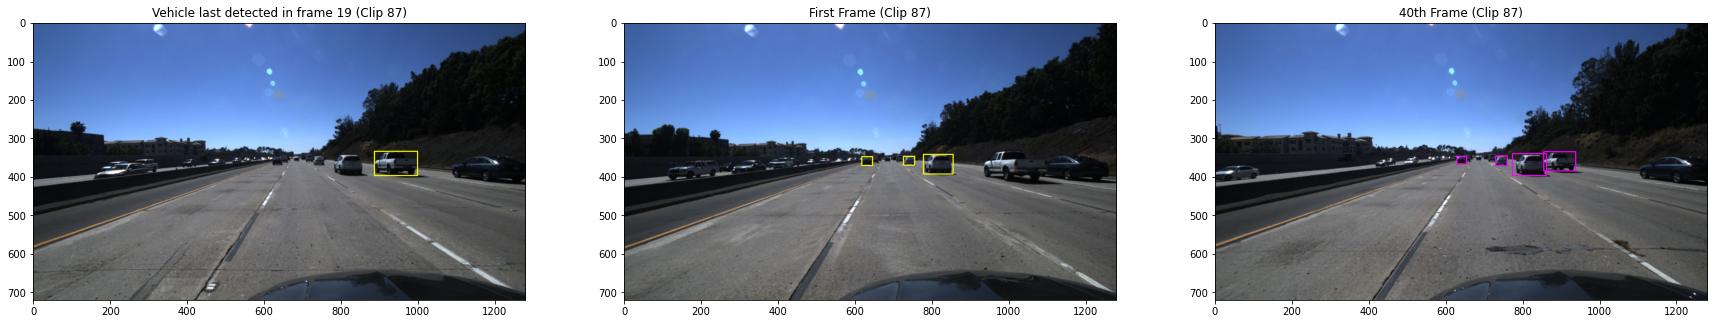

In [ ]:
from torchvision.transforms import transforms as transforms
plt.rcParams.update({'figure.max_open_warning': 0})
transform = transforms.Compose([
    transforms.ToTensor()
])

# Used to store difference in velocity between ground truth and predicted velocities
x_velocity_diff = []
y_velocity_diff = []
velocities_pred = []
velocities_gt = []


# Loop between clip 1 to 100 (clip number is x+1)
for x in range(86,87):

  # Get the list of images in clip (x+1) in test_dir
  images = get_images(TEST_DIR, x+1)

  # Get 40th Frame
  image40 = images[39]

  # Convert PIL to Tensor
  image40_tensor = transform(image40)

  # Find vehicles and their bboxes in the 40th frame
  final_bboxes = get_prediction_bboxes(image40_tensor)
  previous_bboxes = final_bboxes.copy()
  
  # Duration of each clip
  duration = 2 # seconds

  # Used to store last (first) frame each vehicle was detected in
  last_frame = [40] * len(final_bboxes)

  # Loop between frame 39 to 1 of a clip
  for i in range(38, -1, -1):
    # Get i-th Frame of a clip
    imagei = images[i]

    # Convert PIL to Tensor
    imagei_tensor = transform(imagei)

    # Find vehicles and their bboxes in the i-th frame
    current_bboxes = get_prediction_bboxes(imagei_tensor)
    
    # Compare current bbox with previous bbox and match identical boxes
    for index, bbox in enumerate(previous_bboxes):
      for cbbox in current_bboxes:
        # If the boxes have high IoU then it's most likely the same vehicle
        if get_iou(bbox, cbbox) > 0.6:
          previous_bboxes[index] = cbbox

          # Update last frame vehicle was seen in
          last_frame[index] = i+1

  # Used to store x and y velocity tuples for each bounding box
  velocity = []
  for i in range(len(final_bboxes)):
    print(f"Bounding Box {i} (Clip {x+1}):", final_bboxes[i])
    final_distance = calculate_distance(final_bboxes[i])
    print("Distance in Last image:", final_distance[0], final_distance[1])

    initial_distance = calculate_distance(previous_bboxes[i])
    print("Distance in Earliest image:", initial_distance[0], initial_distance[1])

    x_diff = final_distance[0] - initial_distance[0]
    y_diff = final_distance[1] - initial_distance[1]

    # Number of frames elapsed x length (duration) of each frame
    elapsed_time = (41 - last_frame[i])*0.05
    x_velocity = x_diff/elapsed_time
    y_velocity = y_diff/elapsed_time
    velocity.append((x_velocity, y_velocity))
    print("Velocity:", x_velocity, y_velocity)

  # For visualising purposes
  #######################################################################################################
  # Used to display images in their first detected frame and final
  axs_size = sum(1 for n in last_frame if n != 1) + 1
  if 1 in last_frame:
    axs_size += 1

  fig, axs = plt.subplots(1, axs_size, figsize=(30, 18))


  firstimage = np.copy(images[0])
  count = 0
  for i, bbox in enumerate(previous_bboxes):
    if last_frame[i] == 1:
      firstimage = cv2.rectangle(firstimage, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,255,0), 2)
    else:
      imageframe = np.copy(images[last_frame[i]-1])
      imageframe = cv2.rectangle(imageframe, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,255,0), 2)
      axs[count].set_title(f'Vehicle last detected in frame {last_frame[i]} (Clip {x+1})')
      axs[count].imshow(imageframe)
      count +=1
  
  if 1 in last_frame:
    axs[axs_size-2].set_title(f'First Frame (Clip {x+1})')
    axs[axs_size-2].imshow(firstimage)

  lastImage = np.copy(images[39])
  for i, bbox in enumerate(final_bboxes):
    # textx = f"x:{round(velocity[i][0], 5)}m/s"
    # texty = f"y:{round(velocity[i][1], 5)}m/s"
    lastImage = cv2.rectangle(lastImage, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,0,255), 2)
    # lastImage = cv2.putText(lastImage, textx, (bbox[0],bbox[1]-30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.FILLED)
    # lastImage = cv2.putText(lastImage, texty, (bbox[0],bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.FILLED)

  axs[axs_size-1].set_title(f'40th Frame (Clip {x+1})')
  axs[axs_size-1].imshow(lastImage)
  #######################################################################################################

  # Get the ground truth bounding boxes in the dataset of clip x+1
  _, t = dataset_test[x]

  gt_boxes = t['allboxes']
  gt_velocity = t['velocity']

  for i, bbox in enumerate(gt_boxes):
    # Find matching box in final_bboxes
    for j, mbbox in enumerate(final_bboxes):
      if get_iou(bbox, mbbox) > 0.4:
        # Compare difference in velocities
        gt_vel = gt_velocity[i]
        predicted_vel = velocity[j]
        x_vel_diff = gt_vel[0] - predicted_vel[0]
        y_vel_diff = gt_vel[1] - predicted_vel[1]
        x_velocity_diff.append(abs(x_vel_diff))
        y_velocity_diff.append(abs(y_vel_diff))
        velocities_gt.append(gt_vel)
        velocities_pred.append(predicted_vel)
        print(f"Predicted Velocity for Bounding Box {j}:", predicted_vel)
        print(f"Ground Truth Velocity for Bounding Box {j}:", gt_vel)
  print("")
  


print("Average x velocity difference (gt vs predicted):", sum(x_velocity_diff)/len(x_velocity_diff))
print("Number of x values", len(x_velocity_diff))
print("Average y velocity difference (gt vs predicted):", sum(y_velocity_diff)/len(y_velocity_diff))
print("Number of y values", len(y_velocity_diff))


### Evaluating predicted velocities

#### Average velocity difference between ground truth and predicted

In [ ]:
### Results for velocity detection above
print("Average x velocity difference (gt vs predicted):", sum(x_velocity_diff)/len(x_velocity_diff))
# print("Number of x values", len(x_velocity_diff))
print("Average y velocity difference (gt vs predicted):", sum(y_velocity_diff)/len(y_velocity_diff))
# print("Number of y values", len(y_velocity_diff))


Average x velocity difference (gt vs predicted): 0.9667709073206275
Number of x values 130
Average y velocity difference (gt vs predicted): 0.24891646341946982
Number of y values 130


#### Similarity Scores

In [ ]:
# Scaled between 0 to 1 so larger velocities will not have greater but equal weight/affect on similarity score
x_velocity_scaler = preprocessing.MinMaxScaler((0, 1))
y_velocity_scaler = preprocessing.MinMaxScaler((0, 1))
x_velocities_pred = [x[0] for x in velocities_pred]
x_velocities_gt = [x[0] for x in velocities_gt]
y_velocities_pred = [y[1] for y in velocities_pred]
y_velocities_gt = [y[1] for y in velocities_gt]
scaled_x_velocities = x_velocity_scaler.fit_transform(np.array(x_velocities_gt).reshape(-1,1))
scaled_x_velocities_pred = x_velocity_scaler.transform(np.array(x_velocities_pred).reshape(-1,1))
sum_gt = np.sum(scaled_x_velocities.reshape(1,-1))
sum_pred = np.sum(scaled_x_velocities_pred.reshape(1,-1))
print(f"Similarity between ground truth and predicted x velocities: {min(sum_gt,sum_pred)/max(sum_gt,sum_pred)*100}%")


scaled_y_velocities = y_velocity_scaler.fit_transform(np.array(y_velocities_gt).reshape(-1,1))
scaled_y_velocities_pred = y_velocity_scaler.transform(np.array(y_velocities_pred).reshape(-1,1))
sum_gt = np.sum(scaled_y_velocities.reshape(1,-1))
sum_pred = np.sum(scaled_y_velocities_pred.reshape(1,-1))
print(f"Similarity between ground truth and predicted y velocities: {min(sum_gt,sum_pred)/max(sum_gt,sum_pred)*100}%")

Similarity between ground truth and predicted x velocities: 98.13119237349477%
Similarity between ground truth and predicted y velocities: 96.70318804644938%


#### Visualising Predicted vs Ground Truth Velocities

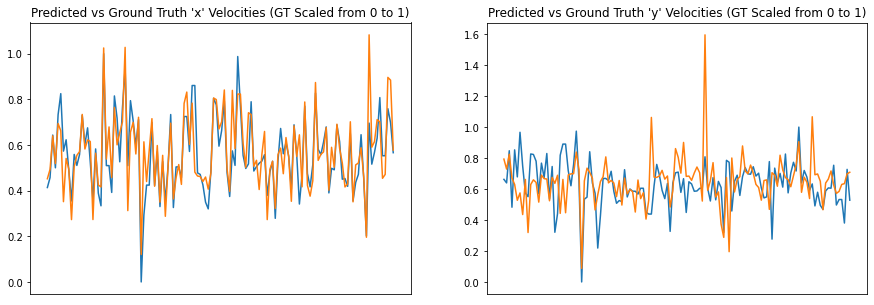

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title("Predicted vs Ground Truth 'x' Velocities (GT Scaled from 0 to 1)")
axs[0].plot(scaled_x_velocities.reshape(1,-1)[0])
axs[0].plot(scaled_x_velocities_pred.reshape(1,-1)[0])
axs[0].axes.xaxis.set_visible(False)

axs[1].set_title("Predicted vs Ground Truth 'y' Velocities (GT Scaled from 0 to 1)")
axs[1].plot(scaled_y_velocities.reshape(1,-1)[0])
axs[1].plot(scaled_y_velocities_pred.reshape(1,-1)[0])
axs[1].axes.xaxis.set_visible(False)

plt.show()

### Using a single object tracker included in cv2 for comparison

In [ ]:
from torchvision.transforms import transforms as transforms
plt.rcParams.update({'figure.max_open_warning': 0})
transform = transforms.Compose([
    transforms.ToTensor()
])

# Used to store difference in velocity between ground truth and predicted velocities
x_velocity_diff = []
y_velocity_diff = []
velocities_pred = []
velocities_gt = []


# Loop between clip 1 to 100 (clip number is x+1)
for x in range(0,100):

  # Get the list of images in clip (x+1) in test_dir
  images = get_images(TEST_DIR, x+1)

  # Get 40th Frame
  image40 = images[39]

  # Convert PIL to Tensor
  image40_tensor = transform(image40)

  images = [np.array(pil_image)  for pil_image in images]

  # Find vehicles and their bboxes in the 40th frame
  final_bboxes = get_prediction_bboxes(image40_tensor)
  last_frame_and_bbox = []
  for bbox in final_bboxes:
    tracker = cv2.TrackerMIL_create()

    # bbox needs to be in format: left, top, w, h
    # currently in left, top, right, bottom
    left, top, right, bottom = bbox[0], bbox[1], bbox[2], bbox[3]
    box = (left, top, right-left, bottom-top)
    # plt.imshow(images[39])
    # print(box)
    tracker.init(images[39], box)
    last_bbox = box
    last_index = 39
    for i in range(38, -1, -1):
      success, bbox = tracker.update(images[i])
      if not success:
        break
      else:
        bbox1 = (bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3])
        bbox2 = (last_bbox[0], last_bbox[1], last_bbox[0]+last_bbox[2], last_bbox[1]+last_bbox[3])
        if get_iou(bbox1, bbox2) > 0.6:
          last_bbox = bbox
          last_index -= 1
        else:
          break

    reformatted_bbox = (int(last_bbox[0]), int(last_bbox[1]), int(last_bbox[0]+last_bbox[2]), int(last_bbox[1]+last_bbox[3]))
    last_frame_and_bbox.append((last_index, reformatted_bbox))


  # Used to store x and y velocity tuples for each bounding box
  velocity = []
  for i in range(len(last_frame_and_bbox)):
    print(f"Bounding Box {i} (Clip {x+1}):", final_bboxes[i])
    final_distance = calculate_distance(final_bboxes[i])
    print("Distance in Last image:", final_distance[0], final_distance[1])

    initial_distance = calculate_distance(last_frame_and_bbox[i][1])
    print("Distance in Earliest image:", initial_distance[0], initial_distance[1])

    x_diff = final_distance[0] - initial_distance[0]
    y_diff = final_distance[1] - initial_distance[1]

    # Number of frames elapsed x length (duration) of each frame
    elapsed_time = (40 - last_frame_and_bbox[i][0])*0.05
    x_velocity = x_diff/elapsed_time
    y_velocity = y_diff/elapsed_time
    velocity.append((x_velocity, y_velocity))
    print("Velocity:", x_velocity, y_velocity)


  _, t = dataset_test[x]

  gt_boxes = t['allboxes']
  gt_velocity = t['velocity']

  for i, bbox in enumerate(gt_boxes):
    # Find matching box in final_bboxes
    for j, mbbox in enumerate(final_bboxes):
      if get_iou(bbox, mbbox) > 0.4:
        # Compare difference in velocities
        gt_vel = gt_velocity[i]
        predicted_vel = velocity[j]
        x_vel_diff = gt_vel[0] - predicted_vel[0]
        y_vel_diff = gt_vel[1] - predicted_vel[1]
        x_velocity_diff.append(abs(x_vel_diff))
        y_velocity_diff.append(abs(y_vel_diff))
        velocities_gt.append(gt_vel)
        velocities_pred.append(predicted_vel)
        print(f"Predicted Velocity for Bounding Box {j}:", predicted_vel)
        print(f"Ground Truth Velocity for Bounding Box {j}:", gt_vel)
  
  # For visualising purposes
  #######################################################################################################
  # Used to display images in their first detected frame and final
  axs_size = sum(1 for n in last_frame_and_bbox if n[0] != 0) + 1
  if 0 in [a[0] for a in last_frame_and_bbox]:
    axs_size += 1

  fig, axs = plt.subplots(1, axs_size, figsize=(20, 12))


  firstimage = np.copy(images[0])
  count = 0
  for i, bbox in enumerate(last_frame_and_bbox):
    if bbox[0] == 0:
      firstimage = cv2.rectangle(firstimage, (bbox[1][0],bbox[1][1]), (bbox[1][2],bbox[1][3]), (255,255,0), 2)
    else:
      imageframe = np.copy(images[last_frame_and_bbox[i][0]])
      imageframe = cv2.rectangle(imageframe, (bbox[1][0],bbox[1][1]), (bbox[1][2],bbox[1][3]), (255,255,0), 2)
      axs[count].set_title(f'Vehicle last detected in frame {bbox[0]} (Clip {x+1})')
      axs[count].imshow(imageframe)
      count +=1
  
  if 0 in [a[0] for a in last_frame_and_bbox]:
    axs[axs_size-2].set_title(f'First Frame (Clip {x+1})')
    axs[axs_size-2].imshow(firstimage)

  lastImage = np.copy(images[39])
  for i, bbox in enumerate(final_bboxes):
    textx = f"x:{round(velocity[i][0], 5)}m/s"
    texty = f"y:{round(velocity[i][1], 5)}m/s"
    lastImage = cv2.rectangle(lastImage, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,0,255), 2)
    lastImage = cv2.putText(lastImage, textx, (bbox[0],bbox[1]-30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.FILLED)
    lastImage = cv2.putText(lastImage, texty, (bbox[0],bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.FILLED)

  axs[axs_size-1].set_title(f'40th Frame (Clip {x+1})')
  axs[axs_size-1].imshow(lastImage)
  #######################################################################################################
  print("")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### Results for velocity detection above
print("Average x velocity difference (gt vs predicted):", sum(x_velocity_diff)/len(x_velocity_diff))
print("Number of x values", len(x_velocity_diff))
print("Average y velocity difference (gt vs predicted):", sum(y_velocity_diff)/len(y_velocity_diff))
print("Number of y values", len(y_velocity_diff))


Average x velocity difference (gt vs predicted): 2.2918060417097146
Number of x values 130
Average y velocity difference (gt vs predicted): 0.34234689517193123
Number of y values 130


In [ ]:
# Scaled between 0 to 1 so larger velocities will not have greater but equal weight/affect on similarity score
x_velocity_scaler = preprocessing.MinMaxScaler((0.1, 1))
y_velocity_scaler = preprocessing.MinMaxScaler((0.1, 1))
x_velocities_pred = [x[0] for x in velocities_pred]
x_velocities_gt = [x[0] for x in velocities_gt]
y_velocities_pred = [y[1] for y in velocities_pred]
y_velocities_gt = [y[1] for y in velocities_gt]
scaled_x_velocities = x_velocity_scaler.fit_transform(np.array(x_velocities_gt).reshape(-1,1))
scaled_x_velocities_pred = x_velocity_scaler.transform(np.array(x_velocities_pred).reshape(-1,1))
sum_gt = np.sum(scaled_x_velocities.reshape(1,-1))
sum_pred = np.sum(scaled_x_velocities_pred.reshape(1,-1))
print(f"Similarity between ground truth and predicted x velocities: {min(sum_gt,sum_pred)/max(sum_gt,sum_pred)*100}%")


scaled_y_velocities = y_velocity_scaler.fit_transform(np.array(y_velocities_gt).reshape(-1,1))
scaled_y_velocities_pred = y_velocity_scaler.transform(np.array(y_velocities_pred).reshape(-1,1))
sum_gt = np.sum(scaled_y_velocities.reshape(1,-1))
sum_pred = np.sum(scaled_y_velocities_pred.reshape(1,-1))
print(f"Similarity between ground truth and predicted y velocities: {min(sum_gt,sum_pred)/max(sum_gt,sum_pred)*100}%")

Similarity between ground truth and predicted x velocities: 91.91666581095113%
Similarity between ground truth and predicted y velocities: 93.70741471202457%


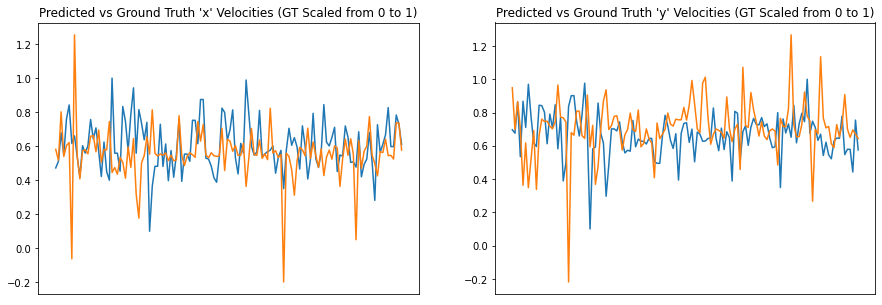

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title("Predicted vs Ground Truth 'x' Velocities (GT Scaled from 0 to 1)")
axs[0].plot(scaled_x_velocities.reshape(1,-1)[0])
axs[0].plot(scaled_x_velocities_pred.reshape(1,-1)[0])
axs[0].axes.xaxis.set_visible(False)

axs[1].set_title("Predicted vs Ground Truth 'y' Velocities (GT Scaled from 0 to 1)")
axs[1].plot(scaled_y_velocities.reshape(1,-1)[0])
axs[1].plot(scaled_y_velocities_pred.reshape(1,-1)[0])
axs[1].axes.xaxis.set_visible(False)

plt.show()